# Using Machine Learning to Predict the Weather: Part 3

This is the final article on using machine learning in Python to make predictions of the mean temperature based off of meteorological weather data retrieved from [Weather Underground](www.weatherunderground.com) as described in [part one](http://stackabuse.com/using-machine-learning-to-predict-the-weather-part-1/) of this series. The topic of this final article will be a to build a neural network regressor using Google's Open Source [TensorFlow](www.tensorflow.org).  For a general introduction into TensorFlow as well a discussion of installation methods please see Mihajlo Pavloski's excellent post [TensorFlow Neural Network Tutorial](http://stackabuse.com/tensorflow-neural-network-tutorial/). Topics I will be covering in this article include:

* Wrapping Your Head Around Artificial Neural Network Theory
* TensorFlow's High Level Estimator API and Pre-canned Models
* Building a DNNRegressor to Predict the Weather

### Wrapping Your Head Around Artificial Neural Networks Theory

In the [last article](http://stackabuse.com/using-machine-learning-to-predict-the-weather-part-2/) I described the process of building a linear regression model, a venerable machine learning technique that underlies many others, to predict the mean daily temperature in Lincoln, Nebraska.  Linear regression models are extremely powerful and have been used to make numerical as well as categorical predictions since well before the term machine learning was ever coined.  However, the technique has some criticisms mostly around its ridged assumption of a linear relationship between the dependent variable and the independent variable(s).  

An uncountable number of other algorithms exist in the data science and machine learning industry which overcome this assumption of linearity.  One of the more popular areas of focus in recent years has been to apply [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network) to a vast array of machine learning problems.  Neural networks have a powerful way of utilizing learning techniques based on both linear and non-linear operations.

Neural networks are inspired by biological neurons in the brain which work in a complex network of interactions to transmit, collect, and learn information based off a history of the information that has been collected. The computational neural networks we are interested in are similar to the neurons of the brain in that they are a collection of neurons (nodes) that receive input signals (numerical quantities), process the input and, transmits the processed signals to other downstream agents in the network.  The processing of signals as numerical quantities that pass through the neural network is a very powerful feature that is not limited to linear relationships.

In this series I have been focusing on a specific type of machine learning called supervised learning which simply means that the models being trained are built using data that has known target outcomes that the model is trying to learn to predict.  Furthermore, the type of predictions being made are numerical real values which means we are dealing with *regressor* prediction algorithms. 

Graphically, a neural network similar to the one being described in this article is shown in the image below.

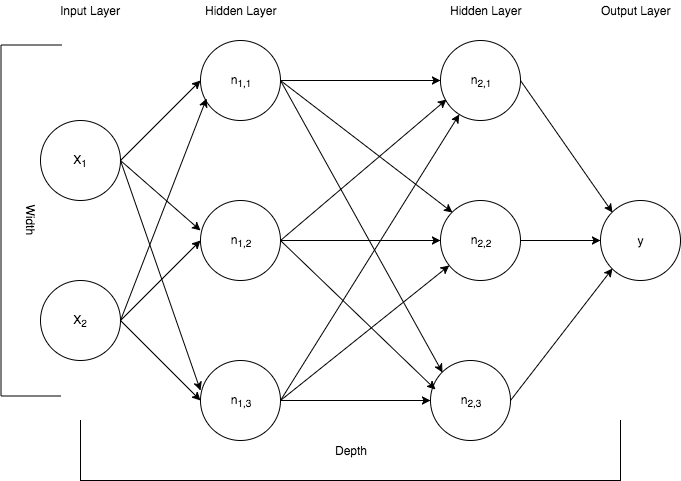

The neural network depicted above contains an input layer on the far left representing two features, x1 and x2, that are feeding the neural network.  Those two features are fed into the neural network which are processed and transmitted through two layers of neurons which are referred to as hidden layers. This depiction shows two hidden layers with each layer containing three neurons (nodes).  The signal then exits the neural network and is aggregated at the output layer as a single numerical predicted value. 

Let me take a moment to explain the meaning behind the arrows signifying data being processed from node to node across the layers.  Each arrow represents a mathematical transformation of a value beginning at the arrow's base which is then multiplied by a weight specific to that path.  Each node within a layer will be fed a value in this way. Then all the values converging at the node are summed.  It is this aggregate of multiplying by weights and summing the products that define the linear operations of a neural network I mentioned earlier. 

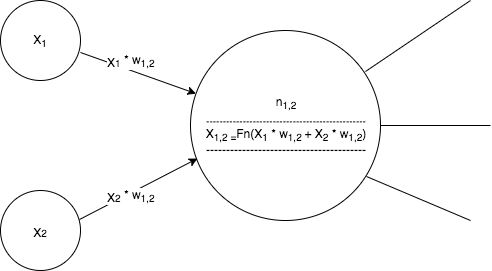

After summation is carried out at each node a special, non-linear, function is applied to the sum which is depicted in the image above as **Fn(...)**.  This special function that introduces non-linear characteristics into a neural network is called an activation function.  It is this non-linear characteristic brought about by activation functions that give multilayer neural networks their power.  If it was not for the non-linearity added to the process then all layers would effectively just algebraically combine into one constant operation consisting of multiplying the inputs by some flat coefficient value (ie, a linear model). 

Alright, so that is all fine and dandy but, I hope you are wondering in the back of your mind ... ok, Adam, but how does this translate into a learning algorithm?  Well the most straight forward answer to that is to evaluate the predictions being made, the output of the model y, to the actual expected values (the targets) and make a series of adjustments to the weights in a manner that improves the overall prediction accuracy. 

In the world of regressor machine learning algorithms one evaluates the accuracy by using a cost (aka, loss, or objective) function, namely the sum of squared errors (SSE).  Notice that I generalized that statement to the whole continuum of machine learning, not just neural networks.  In the prior article the Ordinary Least Squares algorithm accomplished just that, it found the combinations of coefficients that minimized the sum of the squared errors (ie, least squares).  Our neural network regressor will do the exact same thing. It will iterate over the training data feeding in feature values, calculate the cost function (SSE) and make adjustments to the weights in a way that minimizes the cost function.  This process of iteratively pushing features through the algorithm and evaluating how to adjust the weights based off the cost function is, in essence, what is known as model optimization.  

Model optimization algorithms are very important in building robust neural networks.  As examples are fed through the networks architecture (ie, the width and depth) then evaluated against the cost function, the weights are adjusted. The models is said to be learning when the optimizer function identifies that a weight adjustment was made in a way that does not improve (lower) the cost function which is registered with the optimizer so that it does not adjust the weights in that direction again.

### TensorFlow's High Level Estimator API and Pre-canned Models 

Google's TensorFlow library consists a few API's with the most popular being the Core API which gives the user a low level set of tools to define and train essentially any machine learning algorithm using symbolic operations.  This is referred to as TensorFlow Core.  While TensorFlow Core is an amazing API with vast application capability I will be focusing on a newer, higher level, API the TensorFlow team developed that is collectively referred to as the Estimator API.

The TensorFlow team developed the Estimator API to make the library more accessible to the everyday developer.  This high level API provides a common interface to `train(...)` models, `evaluate(...)` models, and `predict(...)` outcomes of unknown cases similar to (and influenced by) the popular Sci-Kit Learn library which is accomplished by implementing a common interface.  Also, built into the high level API are a load of machine learning best practices, abstractions, and ability for scalability.

All of this machine learning goodness brings about a set of tools implemented in the base Estimator class as well as multiple pre-canned model types that lowers the barrier to entry for using TensorFlow so it can be applied to a host of everyday problems (or opportunities).  By abstracting away much of the mundane and manual aspects of things like writing training loops or dealing with sessions the developer is able to focus on more important things like rapidly trying multiple models and model architectures to find the one that best fits their need.  I will be describing how to use one of the very powerful deep neural network estimators, the DNNRegressor.

### Building a DNNRegressor to Predict the Weather

Let me start by importing a number of different libraries that I will use to build the model

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split

Now let us get our hands on the data and take a couple of peaks at it again to familiarize ourselves with it.  I have placed all the code and data in my GitHub repo [here](https://github.com/amcquistan/WeatherPredictPythonML) so that readers can follow along.

In [3]:
# read in the csv data into a pandas data frame and set the date as the index
df = pd.read_csv('end-part2_df.csv').set_index('date')

# execute the describe() function and transpose the output so that it doesn't overflow the width of the screen
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantempm,997.0,13.129388,10.971591,-17.0,5.0,15.0,22.00,32.00
maxtempm,997.0,19.509529,11.577275,-12.0,11.0,22.0,29.00,38.00
mintempm,997.0,6.438315,10.957267,-27.0,-2.0,7.0,16.00,26.00
meantempm_1,997.0,13.109328,10.984613,-17.0,5.0,15.0,22.00,32.00
meantempm_2,997.0,13.088265,11.001106,-17.0,5.0,14.0,22.00,32.00
meantempm_3,997.0,13.066199,11.017312,-17.0,5.0,14.0,22.00,32.00
meandewptm_1,997.0,6.440321,10.596265,-22.0,-2.0,7.0,16.00,24.00
meandewptm_2,997.0,6.420261,10.606550,-22.0,-2.0,7.0,16.00,24.00
meandewptm_3,997.0,6.393180,10.619083,-22.0,-2.0,7.0,16.00,24.00
meanpressurem_1,997.0,1016.139418,7.582453,989.0,1011.0,1016.0,1021.00,1040.00


In [4]:
# execute the info() function
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 2015-01-04 to 2017-09-27
Data columns (total 39 columns):
meantempm          997 non-null int64
maxtempm           997 non-null int64
mintempm           997 non-null int64
meantempm_1        997 non-null float64
meantempm_2        997 non-null float64
meantempm_3        997 non-null float64
meandewptm_1       997 non-null float64
meandewptm_2       997 non-null float64
meandewptm_3       997 non-null float64
meanpressurem_1    997 non-null float64
meanpressurem_2    997 non-null float64
meanpressurem_3    997 non-null float64
maxhumidity_1      997 non-null float64
maxhumidity_2      997 non-null float64
maxhumidity_3      997 non-null float64
minhumidity_1      997 non-null float64
minhumidity_2      997 non-null float64
minhumidity_3      997 non-null float64
maxtempm_1         997 non-null float64
maxtempm_2         997 non-null float64
maxtempm_3         997 non-null float64
mintempm_1         997 non-null float64
mintempm_2

Note that we have just under a 1000 records of meteorological data and that all the features are numerical in nature. Also, because of our hard work in the first article, all of the records are complete in that they are not missing (no non-nulls) any values.  

Now I will remove the mintempm and maxtempm columns as they have no meaning in helping us predict the average mean temperatures, we are predicting the future so we obviously can not have data about the future.  I will also separate out the features (X) from the targets (y).

In [5]:
# First drop the maxtempm and mintempm from the dataframe
df = df.drop(['mintempm', 'maxtempm'], axis=1)

# X will be a pandas dataframe of all columns except meantempm
X = df[[col for col in df.columns if col != 'meantempm']]

# y will be a pandas series of the meantempm
y = df['meantempm']

As with all supervised machine learning applications, I will be dividing my dataset into training and testing sets.  However, to better explain the iterative process of training this neural network I will be using an additional dataset I will refer to as a validation set.  For the training set I will be utilizing 80 percent of the data and for the testing and validation set they will each be 10% of the remaining data. To split out this data I will again be using Sci-Kit Learn's `train_test_split(...)`.

In [6]:
# split data into training set and a temporary set using sklearn.model_selection.traing_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)

In [7]:
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

X_train.shape, X_test.shape, X_val.shape
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))

Training instances   797, Training features   36
Validation instances 100, Validation features 36
Testing instances    100, Testing features    36


The first step to take in building a neural network model is to instantiate the `tf.estimator.DNNRegressor(...)` class.  The class constructor has multiple parameters but I will be focusing on the following:

* feature_columns: list-like structure containing a definition of the name and data types for the features being fed into the model
* hidden_units: list-like structure containing a definition of the number width and depth of the neural network
* optimizer: an instance of tf.Optimizer subclass which optimizes the model's weights during training; has a default is the AdaGrad optimizer.
* activation_fn: an activation function used to introduce non-linearity into the network at each layer; the default is ReLU
* model_dir: a directory to be created that will contain metadata and other checkpoint saves for the model

I will begin by defining a list of numeric feature columns.  To do this I use the `tf.feature_column.numeric_column()` function which returns a `FeatureColumn` instance for numeric, continuous, valued features.

In [8]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

With the feature columns defined I can now instantiate the DNNRegressor class and store it in the regressor variable.  I specify that I want a neural network that has two layers deep where both layers have a width of 50 nodes. I also indicate that I want my model data stored in a directory called *tf_wx_model*.

In [9]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': 1, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_model_dir': 'tf_wx_model', '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_session_config': None}


The next thing that I want to do is to define a reusable function that is generically referred to as an input function which I will call `wx_input_fn(...)`.  This function will be used to feed data into my neural network during the training and testing phases. There are many different ways to build input functions but, I will be describing how to define and use one based off the `tf.estimator.inputs.pandas_input_fn(...)` since my data is in pandas data structures.

In [10]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

Notice that this `wx_input_fn(...)` function takes in one mandatory and four optional parameters which are then handed off to a TensorFlow input function specifically for pandas data which is returned.  This is a very powerful feature of the tensorflow API (and Python and other languages that treat functions as first class citizens).

The parameters to the function are defined as follows:
* X: the input features to be fed into one of the three DNNRegressor interface methods `train`, `evaluate`, and `predict`
* y: the target values of X, which are optional and will not be supplied to the `predict` call
* num_epochs: optional parameter. An epoch occurs when the algorithm executes over the entire dataset one time.  
* shuffle: optional, specifies whether to randomly select a batch (subset) of the dataset each time the algorithm executes
* batch_size: the number of samples to include each time the algorithm executes

With our input function defined we can now train our neural network on our training dataset.  For readers who are familiar with the TensorFlow high level API you will probably notice that I am being a little unconventional about how I am training my model. That is, at least from the prespective of the current tutorials on the TensorFlow website and other tutorials on the web.  

Normally you will see something like the following when one trains one of these high level API pre-canned models.

```(python)
regressor.train(input_fn=input_fn(training_data, num_epochs=None, shuffle=True), steps=some_large_number)

.....
lots of log info
....
```

Then the author will jump right into demontrating the `evaluate(...)` function and barely hint at describing what it does or why this line of code exists.


```(python)
regressor.evaluate(input_fn=input_fn(eval_data, num_epochs=1, shuffle=False), steps=1)

.....
less log info
....
```

And after this jump straight into executing the `predict(...)` function assuming all is perfect with the trained model.  

```(python)
predictions = regressor.predict(input_fn=input_fn(pred_data, num_epochs=1, shuffle=False), steps=1)
```

For the ML newcomer reading this type of a tutorial I cringe.  There is so much more thought that goes into those three lines of code that warrants more attention.  This, I feel, is the only downside to having a high level API, it becomes very easy to throw together a model without understanding the key points.  I hope to provide a reasonable explanation of how to train and evaluate this neural network in a way that will minimize the risk of dramatically under fitting or overfitting this model to the training data. 

So, without further delay let me define a simple training loop to train the model on the training data and evaluate it periodically on the evaluation data.

In [11]:
evaluations = []
STEPS = 400
for i in range(100):
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluation = regressor.evaluate(input_fn=wx_input_fn(X_val, y_val,
                                                         num_epochs=1,
                                                         shuffle=False),
                                    steps=1)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 1, loss = 1.11335e+07
INFO:tensorflow:global_step/sec: 75.7886
INFO:tensorflow:step = 101, loss = 36981.3 (1.321 sec)
INFO:tensorflow:global_step/sec: 85.0322
INFO:tensorflow:step = 201, loss = 16970.2 (1.176 sec)
INFO:tensorflow:global_step/sec: 80.2411
INFO:tensorflow:step = 301, loss = 12764.0 (1.246 sec)
INFO:tensorflow:Saving checkpoints for 400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 12479.0.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:35:57
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-400
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:35:57
INFO:tensorflow:Saving dict for global step 400: average_loss = 31.1164, global_step = 400, loss = 3111.64
INFO:tensorflow:Starting evaluation at 2017-12-05-13:35:58
INFO:tensorflow:Restoring parameters from tf_wx_m

INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-2800
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:36:47
INFO:tensorflow:Saving dict for global step 2800: average_loss = 17.6181, global_step = 2800, loss = 1761.81
INFO:tensorflow:Starting evaluation at 2017-12-05-13:36:47
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-2800
INFO:tensorflow:Finished evaluation at 2017-12-05-13:36:48
INFO:tensorflow:Saving dict for global step 2800: average_loss = 17.6181, global_step = 2800, loss = 1761.81
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-2800
INFO:tensorflow:Saving checkpoints for 2801 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 2801, loss = 7992.53
INFO:tensorflow:global_step/sec: 61.462
INFO:tensorflow:step = 2901, loss = 7155.37 (1.629 sec)
INFO:tensorflow:global_step/sec: 61.697
INFO:tensorflow:step = 3001, loss = 6845.18 (1.621 sec)
INFO:tens

INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-5200
INFO:tensorflow:Saving checkpoints for 5201 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 5201, loss = 6260.59
INFO:tensorflow:global_step/sec: 73.2926
INFO:tensorflow:step = 5301, loss = 5802.93 (1.366 sec)
INFO:tensorflow:global_step/sec: 80.068
INFO:tensorflow:step = 5401, loss = 5887.15 (1.250 sec)
INFO:tensorflow:global_step/sec: 65.7956
INFO:tensorflow:step = 5501, loss = 6304.08 (1.519 sec)
INFO:tensorflow:Saving checkpoints for 5600 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 6072.56.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:37:41
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-5600
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:37:41
INFO:tensorflow:Saving dict for global step 5600: average_loss = 14.1128, global_step = 5600, loss = 1411.28
INFO:tensorflow:Starting evaluation at 2017-12-05-13:37:41
INFO:tensorflow

INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-8000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:38:27
INFO:tensorflow:Saving dict for global step 8000: average_loss = 12.7401, global_step = 8000, loss = 1274.01
INFO:tensorflow:Starting evaluation at 2017-12-05-13:38:27
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-8000
INFO:tensorflow:Finished evaluation at 2017-12-05-13:38:27
INFO:tensorflow:Saving dict for global step 8000: average_loss = 12.7401, global_step = 8000, loss = 1274.01
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-8000
INFO:tensorflow:Saving checkpoints for 8001 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 8001, loss = 5390.09
INFO:tensorflow:global_step/sec: 78.9099
INFO:tensorflow:step = 8101, loss = 6198.97 (1.269 sec)
INFO:tensorflow:global_step/sec: 80.8353
INFO:tensorflow:step = 8201, loss = 5724.5 (1.237 sec)
INFO:ten

INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-10400
INFO:tensorflow:Saving checkpoints for 10401 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 10401, loss = 5438.04
INFO:tensorflow:global_step/sec: 67.5647
INFO:tensorflow:step = 10501, loss = 5589.21 (1.482 sec)
INFO:tensorflow:global_step/sec: 79.1511
INFO:tensorflow:step = 10601, loss = 5645.29 (1.263 sec)
INFO:tensorflow:global_step/sec: 77.1295
INFO:tensorflow:step = 10701, loss = 4957.49 (1.297 sec)
INFO:tensorflow:Saving checkpoints for 10800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 5223.36.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:39:21
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-10800
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:39:21
INFO:tensorflow:Saving dict for global step 10800: average_loss = 11.8399, global_step = 10800, loss = 1183.99
INFO:tensorflow:Starting evaluation at 2017-12-05-13:39:21
INFO

INFO:tensorflow:Loss for final step: 4828.13.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:40:07
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-13200
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:40:07
INFO:tensorflow:Saving dict for global step 13200: average_loss = 11.4592, global_step = 13200, loss = 1145.92
INFO:tensorflow:Starting evaluation at 2017-12-05-13:40:08
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-13200
INFO:tensorflow:Finished evaluation at 2017-12-05-13:40:08
INFO:tensorflow:Saving dict for global step 13200: average_loss = 11.4592, global_step = 13200, loss = 1145.92
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-13200
INFO:tensorflow:Saving checkpoints for 13201 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 13201, loss = 5202.97
INFO:tensorflow:global_step/sec: 61.7389
INFO:tensorflow:step = 13301, loss = 5247.11 (

INFO:tensorflow:Saving dict for global step 15600: average_loss = 11.6533, global_step = 15600, loss = 1165.33
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-15600
INFO:tensorflow:Saving checkpoints for 15601 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 15601, loss = 5443.42
INFO:tensorflow:global_step/sec: 64.0333
INFO:tensorflow:step = 15701, loss = 5743.57 (1.563 sec)
INFO:tensorflow:global_step/sec: 81.6189
INFO:tensorflow:step = 15801, loss = 5284.28 (1.225 sec)
INFO:tensorflow:global_step/sec: 81.7802
INFO:tensorflow:step = 15901, loss = 5315.2 (1.223 sec)
INFO:tensorflow:Saving checkpoints for 16000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 5551.96.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:41:01
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-16000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:41:01
INFO:tensorflow:Savi

INFO:tensorflow:global_step/sec: 80.0536
INFO:tensorflow:step = 18301, loss = 4921.48 (1.249 sec)
INFO:tensorflow:Saving checkpoints for 18400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 5127.04.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:41:46
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-18400
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:41:46
INFO:tensorflow:Saving dict for global step 18400: average_loss = 10.8561, global_step = 18400, loss = 1085.61
INFO:tensorflow:Starting evaluation at 2017-12-05-13:41:47
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-18400
INFO:tensorflow:Finished evaluation at 2017-12-05-13:41:47
INFO:tensorflow:Saving dict for global step 18400: average_loss = 10.8561, global_step = 18400, loss = 1085.61
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-18400
INFO:tensorflow:Saving checkpoints

INFO:tensorflow:Starting evaluation at 2017-12-05-13:42:31
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-20800
INFO:tensorflow:Finished evaluation at 2017-12-05-13:42:31
INFO:tensorflow:Saving dict for global step 20800: average_loss = 10.8499, global_step = 20800, loss = 1084.99
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-20800
INFO:tensorflow:Saving checkpoints for 20801 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 20801, loss = 5535.69
INFO:tensorflow:global_step/sec: 61.0005
INFO:tensorflow:step = 20901, loss = 5536.07 (1.641 sec)
INFO:tensorflow:global_step/sec: 64.0962
INFO:tensorflow:step = 21001, loss = 5724.86 (1.560 sec)
INFO:tensorflow:global_step/sec: 80.1343
INFO:tensorflow:step = 21101, loss = 5117.09 (1.248 sec)
INFO:tensorflow:Saving checkpoints for 21200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 4648.63.
INFO:tensorflow:Starting evaluation at 2017-12-05-13

INFO:tensorflow:global_step/sec: 74.8609
INFO:tensorflow:step = 23301, loss = 5296.9 (1.338 sec)
INFO:tensorflow:global_step/sec: 83.6059
INFO:tensorflow:step = 23401, loss = 5237.88 (1.196 sec)
INFO:tensorflow:global_step/sec: 83.6666
INFO:tensorflow:step = 23501, loss = 5520.94 (1.195 sec)
INFO:tensorflow:Saving checkpoints for 23600 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 4375.85.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:43:24
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-23600
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:43:24
INFO:tensorflow:Saving dict for global step 23600: average_loss = 10.6117, global_step = 23600, loss = 1061.17
INFO:tensorflow:Starting evaluation at 2017-12-05-13:43:25
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-23600
INFO:tensorflow:Finished evaluation at 2017-12-05-13:43:25
INFO:tensorflow:Saving dict for global step 23600: average_loss =

INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:44:11
INFO:tensorflow:Saving dict for global step 26000: average_loss = 10.4591, global_step = 26000, loss = 1045.91
INFO:tensorflow:Starting evaluation at 2017-12-05-13:44:11
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-26000
INFO:tensorflow:Finished evaluation at 2017-12-05-13:44:11
INFO:tensorflow:Saving dict for global step 26000: average_loss = 10.4591, global_step = 26000, loss = 1045.91
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-26000
INFO:tensorflow:Saving checkpoints for 26001 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 26001, loss = 5467.28
INFO:tensorflow:global_step/sec: 62.2726
INFO:tensorflow:step = 26101, loss = 4855.61 (1.608 sec)
INFO:tensorflow:global_step/sec: 61.6876
INFO:tensorflow:step = 26201, loss = 5185.48 (1.621 sec)
INFO:tensorflow:global_step/sec: 79.5957
INFO:tensorflow:step = 263

INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-28400
INFO:tensorflow:Saving checkpoints for 28401 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 28401, loss = 5180.42
INFO:tensorflow:global_step/sec: 73.7079
INFO:tensorflow:step = 28501, loss = 4822.18 (1.359 sec)
INFO:tensorflow:global_step/sec: 74.4009
INFO:tensorflow:step = 28601, loss = 4205.86 (1.344 sec)
INFO:tensorflow:global_step/sec: 81.1051
INFO:tensorflow:step = 28701, loss = 4977.51 (1.233 sec)
INFO:tensorflow:Saving checkpoints for 28800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 5172.75.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:45:04
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-28800
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:45:04
INFO:tensorflow:Saving dict for global step 28800: average_loss = 10.4509, global_step = 28800, loss = 1045.09
INFO:tensorflow:Starting evaluation at 2017-12-05-13:45:04
INFO

INFO:tensorflow:Loss for final step: 5169.14.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:45:51
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-31200
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:45:52
INFO:tensorflow:Saving dict for global step 31200: average_loss = 10.4394, global_step = 31200, loss = 1043.94
INFO:tensorflow:Starting evaluation at 2017-12-05-13:45:52
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-31200
INFO:tensorflow:Finished evaluation at 2017-12-05-13:45:52
INFO:tensorflow:Saving dict for global step 31200: average_loss = 10.4394, global_step = 31200, loss = 1043.94
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-31200
INFO:tensorflow:Saving checkpoints for 31201 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 31201, loss = 5839.59
INFO:tensorflow:global_step/sec: 62.8904
INFO:tensorflow:step = 31301, loss = 5244.01 (

INFO:tensorflow:Saving dict for global step 33600: average_loss = 10.3085, global_step = 33600, loss = 1030.85
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-33600
INFO:tensorflow:Saving checkpoints for 33601 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 33601, loss = 4548.46
INFO:tensorflow:global_step/sec: 63.6762
INFO:tensorflow:step = 33701, loss = 5151.17 (1.572 sec)
INFO:tensorflow:global_step/sec: 80.1956
INFO:tensorflow:step = 33801, loss = 4262.09 (1.247 sec)
INFO:tensorflow:global_step/sec: 80.7475
INFO:tensorflow:step = 33901, loss = 5091.3 (1.239 sec)
INFO:tensorflow:Saving checkpoints for 34000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 4803.04.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:46:45
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-34000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:46:45
INFO:tensorflow:Savi

INFO:tensorflow:global_step/sec: 66.7728
INFO:tensorflow:step = 36301, loss = 5104.49 (1.498 sec)
INFO:tensorflow:Saving checkpoints for 36400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 5044.35.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:47:33
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-36400
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-05-13:47:33
INFO:tensorflow:Saving dict for global step 36400: average_loss = 10.7207, global_step = 36400, loss = 1072.07
INFO:tensorflow:Starting evaluation at 2017-12-05-13:47:33
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-36400
INFO:tensorflow:Finished evaluation at 2017-12-05-13:47:33
INFO:tensorflow:Saving dict for global step 36400: average_loss = 10.7207, global_step = 36400, loss = 1072.07
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-36400
INFO:tensorflow:Saving checkpoints

INFO:tensorflow:Starting evaluation at 2017-12-05-13:48:20
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-38800
INFO:tensorflow:Finished evaluation at 2017-12-05-13:48:20
INFO:tensorflow:Saving dict for global step 38800: average_loss = 10.5071, global_step = 38800, loss = 1050.71
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-38800
INFO:tensorflow:Saving checkpoints for 38801 into tf_wx_model/model.ckpt.
INFO:tensorflow:step = 38801, loss = 4220.55
INFO:tensorflow:global_step/sec: 62.185
INFO:tensorflow:step = 38901, loss = 4895.32 (1.610 sec)
INFO:tensorflow:global_step/sec: 63.7218
INFO:tensorflow:step = 39001, loss = 4584.95 (1.569 sec)
INFO:tensorflow:global_step/sec: 67.8023
INFO:tensorflow:step = 39101, loss = 4745.88 (1.475 sec)
INFO:tensorflow:Saving checkpoints for 39200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 5357.55.
INFO:tensorflow:Starting evaluation at 2017-12-05-13:

The above loop iterates 100 times. In the body of the loop I call the `train(...)` method of the regressor object passing it my reusable `wx_input_fn(...)` which is in turn passed my training feature set and targets.  I purposefully left the default parameters `num_epochs` equal to `None` which basically says, I don't care how many times you pass over the training set just keep going training the algorithm against each default `batch_size` of `400` (roughly half the size of the training set).  I also left the `shuffle` parameter equal to its default value of `True` so that while training the data is selected randomly to avoid any sequential relationships in the data. The final parameter to the `train(...)` method is `steps` which I set to 400 which means the training set will be batched 400 times per loop.  

This gives me a good time to explain in a more concrete numerical way what the meaning of an epoch is.  Recall from the bullets above that an epoch occurs when all the records of a training set is passed through the neural network to train exactly one time.  So, if we have about 800 (797 to be exact) records in our training set and each batch selects 400 then for every two batches we have accomplished one epoch.  Thus, if we iterate over the over the training set for 100 iterations of 400 steps each with a batch size of 400 (one half an epoch per batch) we get (100 x 400 / 2) 20,000 epochs.

Now you might be wondering why I executed and `evaluate(...)` method for each iteration of the loop and captured its output in a list.  First let me explain what happens each time time the `train(...)` method is fired.  It selects a random batch of training records and pushes them through the network until a prediction is made, and for each record the loss function is calculated.  Then based off the loss calculated the weights are adjusted according to the optimizer's logic which does a pretty good job at making adjustments towards the direction that reduces the overall loss for the next iteration.  These loss values, in general as long as the learning rate is small enough, decline over time with each iteration or step. 

However, after a certain amount of these learning iterations the weights start to be influenced not just by the overall trends in the data but, also by the uninformative noise inherit in virtually all real data.  At this point the network is over influenced by the idiosyncrasies of the training data and becomes unable to gereralize predictions about the overall population of data (ie, data it has not yet seen).  

This relates to the issue I mentioned earlier where many other tutorials on the high level TensorFlow API have fallen short.  It is quite important to break periodically during training and evaluate how the model is generalizing to an evaluation, or validation, dataset. Lets take a moment to look at what the `evaluate(...)` function returns by looking at the first loop iteration's evaluation output.

In [12]:
evaluations[0]

{'average_loss': 31.116383, 'global_step': 400, 'loss': 3111.6382}

As you can see it outputs the average loss (Mean Squared Error) and the total loss (Sum of Squared Errors) for the step in training which for this one is the 400th step. What you will normally see in a highly trained network is a trend where both the training and evaluation losses more or less constantly decline in parallel.  However, in an overfitted model at some point in time, actually at the point where over fitting starts to occur, the validation training set will cease to see reductions in the output of its `evaluate(...)` method.  This is where you want to stop further training the model, preferably right before that change occurs.

Now that we have a collection of evaluations for each of the iterations let us plot them as a function of training steps to ensure we have not over trained our model.  To do so I will use a simple scatter plot from matplotlib's `pyplot` module.

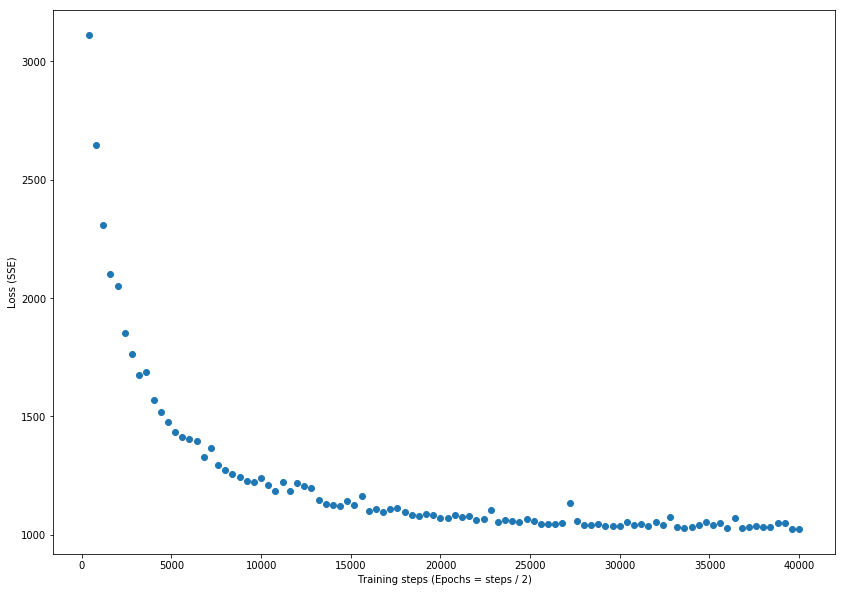

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.show()

Cool! From the chart above it looks like after all those iterations I have not overfitted the model because the evaluation losses never exhibit a significant change in direction toward an increasing value.  Now I can safely move on to making predictions based off my remaining test dataset and assess how the model does as predicting mean weather temperatures.

Similar to the other two regressor method I have demonstrated, the `predict(...)` method requires an input_fn which I will pass in using the reusable `wx_input_fn(...)` handing it the test dataset, specifying the num_epochs to be one and shuffle to be false so that it is sequentially feed all the data to test against.

Next I do some formating of the iterable of dicts that are returned from the `predict(...)` method so that I have a numpy array of predictions.  I then use the array of predictions with the sklearn methods `explained_variance_score(...)`, `mean_absolute_error(...)`, and `median_absolute_error(...)` to measure how well the predictions fared in relation to the known targets `y_test`.  This tells the developer what the predictive capabilities of the model are. 

In [14]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

print("The Explained Variance: %.2f" % explained_variance_score(
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(
                                            y_test, predictions))

INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-40000
The Explained Variance: 0.88
The Mean Absolute Error: 3.11 degrees Celcius
The Median Absolute Error: 2.51 degrees Celcius


I have used the same metrics as the previous article covering the Linear Regression technique so that we can not only evaluate this model but, we can also compare them.  As you can see the two models performed quite similarly with the more simple Linear Regression model being slightly better. However, an astute practitioner would certainly run several experiments varying the hyperparameters (learning rate, width and, depth) of this neural network to fine tune it a bit but, in general this is probably pretty close to the optimal model. 

This brings up a point worth mentioning, it is rarely the case, and definitely not advisable, to simply rely on one model or the most recent hot topic in the machine learning community.  No two datasets are identical and no one model is king.  The only way to determine the best model is to actually try them out.  Then once you have identified the best model there are other trade offs to account for such as interpretability.  

### Conclusion

This article has demonstrated how to use the TensorFlow high level API for the pre-canned Estimator subclass DNNRegressor.  Along the way I have described, in a general sense, the theory of neural networks, how they are trained, and the importance of being cognizant of the dangers of overfitting a model in the process. 

To demonstrate this process of building neural networks I have built a model that is capable of predicting the mean temperature for the next day based off numerical features collected in the first article of this series.  That being said, I would like to take a moment to clarify my intentions for this series.  My primary objective has been not to actually build state of the art forecasting models in either the Linear Regresson article or the current one on neural networks but, my goals have been to accomplish the following:

1. Demonstrate the general process for undertaking an analytics (machine learning, data science, whatever...) project from data collection, data processing, exploratory data analysis, model selection, model building, and model evaluation.
2. Demonstrate how to select meaningful features that do not violate key assumptions of the Linear Regression technique using two popular Python libraries, StatsModels and Scikit Learn.
3. Demonstrate how to use the high level TensorFlow API and give some intuition into what is happening under all those layers of abstraction.
4. Discuss the issues associated with over fitting a model.
5. Explain the importance of experimenting with more than one model type to best solve a problem.

Thank you for reading. I hope you enjoyed this series as much as I did and, as always I welcome comments and criticism.  